# Projet Fraude 



In [162]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
import warnings
warnings.simplefilter('ignore')
#autres

### Importer les dataset

In [49]:
df1 = pd.read_csv("source/Fraud_Data.csv")
df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [50]:
df1["class"].value_counts()

0    136961
1     14151
Name: class, dtype: int64

In [51]:
df1.shape

(151112, 11)

In [52]:
df1.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [53]:
df2 = pd.read_csv("source/IpAddress_to_Country.csv")
df2.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [54]:
df2.shape

(138846, 3)

### Créer une nouvelle colonne `country` en effectuant une jointure entre les deux dataset 

In [55]:
#définir 2 variables de travail
#X := les features à utiliser 
#Y := la target (praix)
Y = []

#construire l'ensemble de donnée prix 
for i, row in df1.iterrows():
    IP = int(row["ip_address"])
    subset = df2[(df2["lower_bound_ip_address"] <= IP) & (df2["upper_bound_ip_address"] >= IP)]
    if subset.shape == (1,3):
        Y.append(subset.iloc[0,:]["country"])
    else:
        Y.append("NA")

Y = np.asarray(Y)
df1["country"] = Y

In [56]:
df1.iloc[:10,:]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,NA
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States


In [57]:
df1["country"].value_counts()

United States     58049
NA                21966
China             12038
Japan              7306
United Kingdom     4490
                  ...  
Myanmar               1
Vanuatu               1
Dominica              1
Niger                 1
Guadeloupe            1
Name: country, Length: 182, dtype: int64

### Créer une nouvelle variable `time_diff` qui sera la différence entre les variables `purchase_time` et `signup_time`

In [58]:
df1["signup_time"] = pd.to_datetime(df1["signup_time"])
df1["purchase_time"] = pd.to_datetime(df1["purchase_time"])
df1["time_diff"] = df1["purchase_time"] - df1["signup_time"]
df1["time_diff"] = df1["time_diff"] / np.timedelta64(1, 's')

In [59]:
df1

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,5261233.0
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,931270.0
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,6681616.0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,5146119.0


### Regroupper les `user_id` par `device_id`  afin d'avoir le nombre de device par client  

In [60]:
# Attention, énoncé erroné
dfbis = df1[["user_id","device_id"]].groupby("device_id").count().reset_index()
dfbis = dfbis.rename(columns={"user_id": "user_by_device"})

df1 = df1.merge(dfbis, how="left", on="device_id")

In [70]:
df1

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,user_by_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,5261233.0,2
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,931270.0,1
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,6681616.0,1
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,5146119.0,2


### Faire de même pour les `ip_address` 

In [73]:
dfter = df1[["ip_address","user_id"]].groupby("ip_address").count().reset_index()
dfter = dfter.rename(columns={"user_id": "user_by_ip"})

df1 = df1.merge(dfter, how="left", on="ip_address")

In [74]:
df1

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,user_by_device,user_by_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,5261233.0,2,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,931270.0,1,1
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,6681616.0,1,1
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,5146119.0,2,1


### Traiter les variables `signup_time` & `purchase_time` afin de les différentier suivant la semaine et le week end  

In [113]:
df1['signup_day'] = df1['signup_time'].apply(lambda x: x.dayofweek)
df1['signup_week'] = df1['signup_time'].apply(lambda x: x.week)

df1['purchase_day'] = df1['purchase_time'].apply(lambda x: x.dayofweek)
df1['purchase_week'] = df1['purchase_time'].apply(lambda x: x.week)
df1

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,user_by_device,user_by_ip,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,1,30,2,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,5261233.0,2,1,1,5,6,13
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,931270.0,1,1,4,20,1,22
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,6681616.0,1,1,1,10,2,21
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,5146119.0,2,1,3,28,0,37


### Définir vos variables de travail (X,y)

In [115]:
df = df1[["signup_day", "signup_week", "purchase_day", "purchase_week", "purchase_value",
          "source", "browser", "sex", "age", "country", "time_diff", "user_by_device", 
          "user_by_ip", "class"
         ]]

In [116]:
df.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,user_by_device,user_by_ip,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,4506682.0,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944.0,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1.0,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,492085.0,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,4361461.0,1,1,0


### Afficher les informations du dataset afin de vizualiser les variables numeriques et categoriques

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   signup_day      151112 non-null  int64  
 1   signup_week     151112 non-null  int64  
 2   purchase_day    151112 non-null  int64  
 3   purchase_week   151112 non-null  int64  
 4   purchase_value  151112 non-null  int64  
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   country         151112 non-null  object 
 10  time_diff       151112 non-null  float64
 11  user_by_device  151112 non-null  int64  
 12  user_by_ip      151112 non-null  int64  
 13  class           151112 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 21.3+ MB


### Traiter les variables catégoriques

In [120]:
source_encoder = LabelEncoder()
browser_encoder = LabelEncoder()
sex_encoder = LabelEncoder()
country_encoder = LabelEncoder()
df.source = source_encoder.fit_transform(df.source)
df.browser = browser_encoder.fit_transform(df.browser)
df.sex = sex_encoder.fit_transform(df.sex)
df.country = country_encoder.fit_transform(df.country)

df

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,user_by_device,user_by_ip,class
0,1,9,5,16,34,2,0,1,39,84,4506682.0,1,1,0
1,6,23,0,24,16,0,0,0,53,172,17944.0,1,1,0
2,3,1,3,1,15,2,3,1,53,172,1.0,12,12,1
3,1,18,0,19,44,2,4,1,41,115,492085.0,1,1,0
4,1,30,2,37,39,0,4,1,45,172,4361461.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,1,5,6,13,43,2,0,1,28,172,5261233.0,2,1,1
151108,4,20,1,22,35,2,4,1,32,119,931270.0,1,1,0
151109,1,10,2,21,40,2,2,0,26,84,6681616.0,1,1,0
151110,3,28,0,37,46,2,0,1,37,172,5146119.0,2,1,0


### Spliter vos variables 

In [129]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'class'],df["class"],test_size=0.3, random_state=42)
x_train.shape, x_test.shape

((105778, 13), (45334, 13))

### Instancier un `RandomForestClassifier` et l'entrainer sur vos données 

In [130]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

### Afficher l'accuracy moyenne pour 10 'fold cross validation'

In [135]:
scores = cross_val_score(rfc, x_train, y_train, scoring = "accuracy", cv = 10)

In [136]:
scores

array([0.95613538, 0.95424466, 0.95679713, 0.95944413, 0.95358291,
       0.95764795, 0.95679713, 0.95509548, 0.95282216, 0.95858939])

In [138]:
# Précision moyenne
scores.mean()

0.9561156306632007

### Afficher les `feature_importances_`

In [140]:
rfc.feature_importances_

array([0.0320922 , 0.08851519, 0.03081722, 0.14076874, 0.0657107 ,
       0.01192247, 0.02197101, 0.00947765, 0.05829009, 0.03946679,
       0.25347132, 0.14217879, 0.10531783])

In [147]:
#features importance 
feat_imp = pd.Series(rfc.feature_importances_, index = df.columns[:-1]).sort_values(ascending=False)
feat_imp

time_diff         0.253471
user_by_device    0.142179
purchase_week     0.140769
user_by_ip        0.105318
signup_week       0.088515
purchase_value    0.065711
age               0.058290
country           0.039467
signup_day        0.032092
purchase_day      0.030817
browser           0.021971
source            0.011922
sex               0.009478
dtype: float64

### Vizualiser les sur un graphique 

Text(0.5, 1.0, "Visaluation de l'importance des caractéristiques")

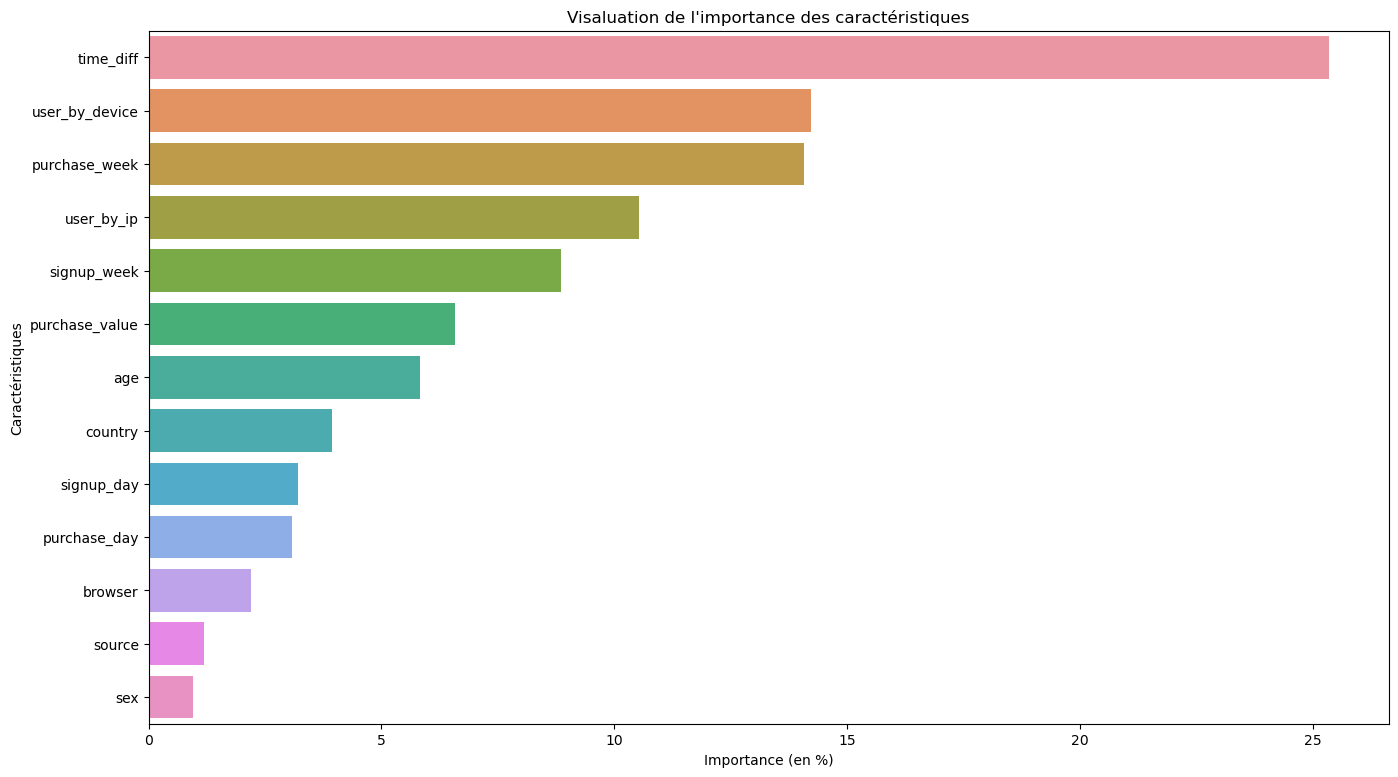

In [148]:
#plot
plt.figure(figsize=(16,9))
sns.barplot(x = feat_imp*100, y = feat_imp.index)
plt.xlabel('Importance (en %)')
plt.ylabel('Caractéristiques')
plt.title("Visaluation de l'importance des caractéristiques")

### Afficher le `Classification report`

In [152]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.99      0.54      0.70      4217

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



### Afficher la matrice de confusion 
Qu'en pensez vous ? 

<AxesSubplot:>

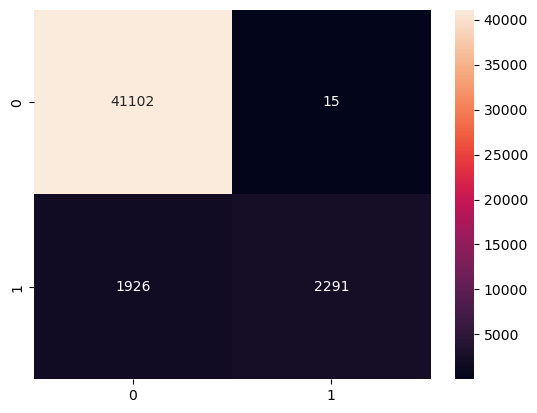

In [156]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='g')

### Traçer la courbe AUC 

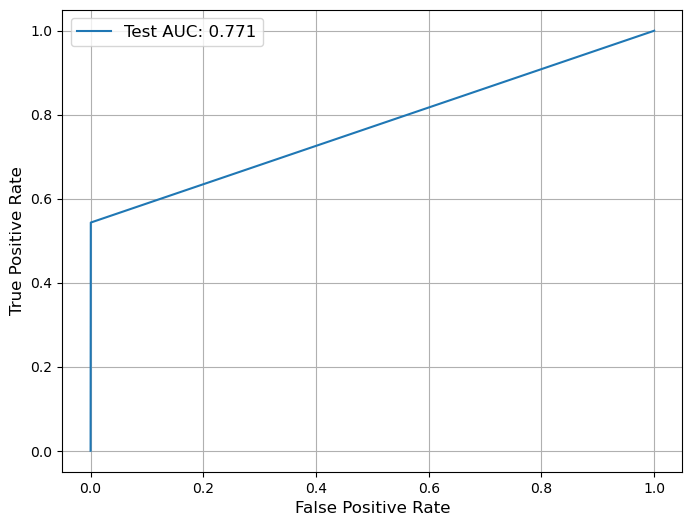

In [159]:
test_fpr, test_tpr, _ = roc_curve(y_test.values, y_pred)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
#ax.plot(test_fpr, test_tpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

### Faire une selection de certaine variables et spliter vos varibales 

In [160]:
XReg = df[["time_diff", "purchase_week", "user_by_device", "user_by_ip"]]
YReg = df[["class"]]

x_train2, x_test2, y_train2, y_test2 = train_test_split(XReg, YReg, test_size=0.3, random_state=42)
x_train2.shape, x_test2.shape

((105778, 4), (45334, 4))

### Entrainer un classifieur `LogisticRegression` sur ces variables 

In [163]:
log_reg = LogisticRegression()
log_reg.fit(x_train2, y_train2)
print(cross_val_score(log_reg, x_train2, y_train2, scoring = "accuracy", cv = 10).mean())

0.9060863323321312
